In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import math 

In [2]:
#Vasicek MOdel Parameter 
# Model parameters drt = alpha(gamma - rt )d_t +sigma(d(z_t))
gamma = 0.03  # Long-term mean of the interest rate
alpha = 0.02  # Speed of mean reversion or kappa
sigma = 0.01  # Volatility of the interest rate
dt = 0.083333  # Time step size


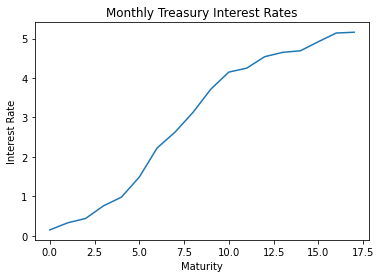

In [3]:
import pandas_datareader.data as web

import datetime

start = datetime.datetime(2022, 1, 1)

end = datetime.datetime(2023, 7, 5)


fred= web.DataReader('TB3MS',"fred", start, end)
df=fred
TBIR=np.array(fred)
# print(TBIR)

#Plot interest rate graph
plt.plot(TBIR)
plt.xlabel('Maturity')
plt.ylabel('Interest Rate')
plt.title('Monthly Treasury Interest Rates')
plt.show()


In [4]:
from scipy.optimize import minimize

# Log-likelihood function
def log_likelihood(params, r):
    alpha, gamma, sigma = params
    N = len(r)
#     dt = 1  # Time increment assumption
    
    var = (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * dt))
    
    log_like = -0.5 * (N - 1) * np.log(2 * np.pi * (sigma**2 / (2 * alpha)) * (1 - np.exp(-2 * alpha * dt))) \
               - 0.5 * np.sum(((r[1:] - (gamma + (r[:-1] - gamma) * np.exp(-alpha * dt))) / np.sqrt(var))**2)
    
    return -log_like  # Minimize negative log-likelihood

# Data
r = TBIR  #  interest rate observations

initial_params = [alpha, gamma, sigma]

# Maximum likelihood estimation
result = minimize(log_likelihood, initial_params, args=(r,))
alpha_hat, gamma_hat, sigma_hat = result.x

print("Maximum Likelihood Estimates:")
print("alpha_hat =", alpha_hat)
print("gamma_hat =", gamma_hat)
print("sigma_hat =", sigma_hat)


Maximum Likelihood Estimates:
alpha_hat = -0.005816586469603514
gamma_hat = -604.6160803249712
sigma_hat = 0.6931426284886264


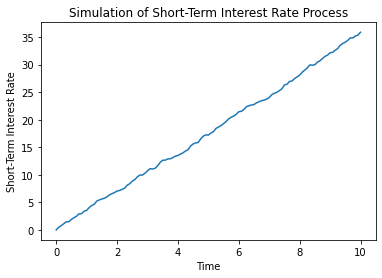

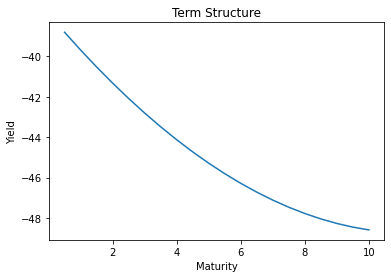

In [7]:
# Simulation of Short-Term Interest Rate Process
def simulate_short_term_interest_rate(alpha_hat, gamma_hat, sigma_hat, r0, T, dt):
    num_steps = int(T / dt)
    r = np.zeros(num_steps + 1)
    r[0] = r0
    
    for i in range(num_steps):
        epsilon = np.random.normal(0, 1)  # Standardized normal random variable
        dr = alpha_hat * (gamma_hat - r[i]) * dt + sigma_hat * epsilon * np.sqrt(dt)
        r[i+1] = r[i] + dr
    
    return r

# Simulation of Term Structure
def simulate_term_structure(alpha_hat, gamma_hat, sigma_hat, r0, T, dt, bond_maturities):
    num_steps = int(T / dt)
    r = simulate_short_term_interest_rate(alpha_hat, gamma_hat, sigma_hat, r0, T, dt)
    
    A = lambda t, T: np.exp(((B(t, T) - T + t) * ((alpha_hat**2 * gamma_hat) - (sigma_hat**2 / 2)) / alpha_hat**2) - ((sigma_hat**2 * B(t, T)**2) / (4 * alpha_hat)))
    B = lambda t, T: (1 - np.exp(-alpha_hat * (T - t))) / alpha_hat
    
    prices = np.zeros(len(bond_maturities))
    yields = np.zeros(len(bond_maturities))
    
    for i, maturity in enumerate(bond_maturities):
        price = A(0, maturity) * np.exp(-B(0, maturity) * r[num_steps])
        prices[i] = price
        yields[i] = -np.log(1 / price) / maturity
    
    return prices, yields

# Parameters and Input Data
# alpha = 0.1
# gamma = 0.03
# sigma = 0.005
r0 = 0.02
T = 10  # Total time in years
# dt = 1/12  # Time increment assumption
bond_maturities = np.arange(0.5, 10.5, 0.5)  # Maturities of zero-coupon bonds

# Simulation of Short-Term Interest Rate Process
short_term_interest_rate = simulate_short_term_interest_rate(alpha_hat, gamma_hat, sigma_hat, r0, T, dt)

# Simulation of Term Structure
bond_prices, bond_yields = simulate_term_structure(alpha_hat, gamma_hat, sigma_hat, r0, T, dt, bond_maturities)

# Plotting the Short-Term Interest Rate Process
# plt.plot(np.arange(0, T+dt, dt), short_term_interest_rate)
# plt.xlabel('Time')
# plt.ylabel('Short-Term Interest Rate')
# plt.title('Simulation of Short-Term Interest Rate Process')
# plt.show()
time = np.arange(0, T+dt, dt)[:len(short_term_interest_rate)]
plt.plot(time, short_term_interest_rate)
plt.xlabel('Time')
plt.ylabel('Short-Term Interest Rate')
plt.title('Simulation of Short-Term Interest Rate Process')
plt.show()
# Plotting the Term Structure
plt.plot(bond_maturities, bond_yields)
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.title('Term Structure')
plt.show()
